<a href="https://colab.research.google.com/github/yasinsoylu1997/128-not-sampling/blob/main/vgg19_models_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.metrics import log_loss
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras
!pip install catboost

In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:07<00:00, 169.53it/s]


In [5]:
train_images, test_images,train_labels, test_labels = train_test_split(X , y , test_size=0.25, random_state=42,shuffle=True)

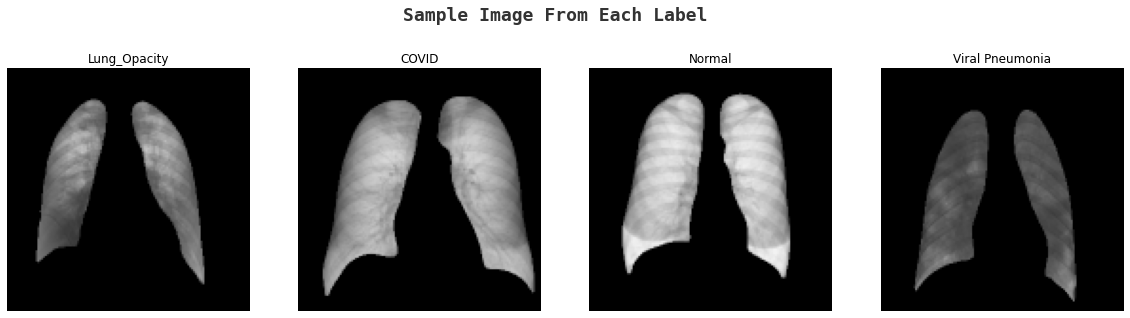

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

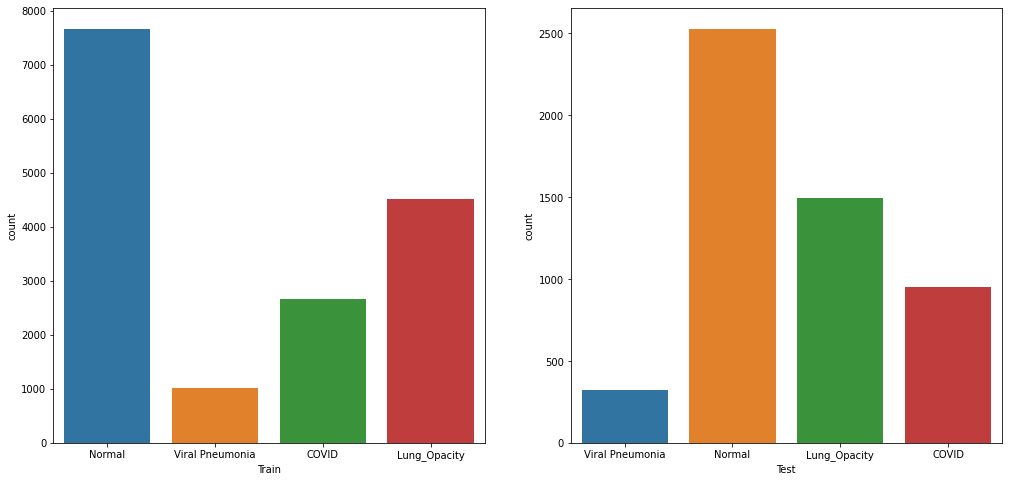

In [7]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [12]:
y_test_one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [13]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [14]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input for model

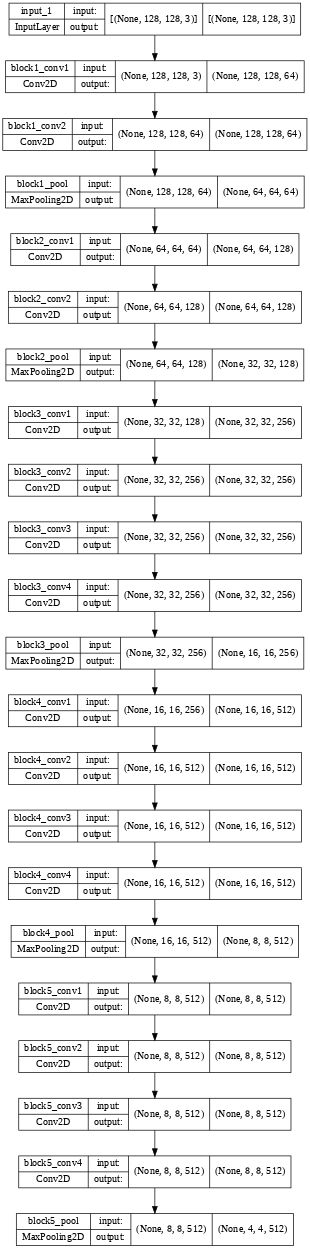

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(VGG_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

In [16]:
import visualkeras
from PIL import ImageFont
#plt.figure(figsize=(2, 2))
#visualkeras.layered_view(VGG_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [17]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [19]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [20]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3119803476946334
MSE: 0.4733560090702948
RMSE: 0.6880087274666614
R2 Square 0.3465243161813423
Accuracy 0.767384731670446
__________________________________


In [21]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_VGG19'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_VGG19
0,KNeighborsClassifier,0.31198,0.473356,0.688009,0.346524,0.767385


In [22]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.68      0.47      0.56       949
           1       0.76      0.70      0.73      1493
           2       0.77      0.92      0.84      2527
           3       0.96      0.80      0.88       323

    accuracy                           0.77      5292
   macro avg       0.79      0.72      0.75      5292
weighted avg       0.76      0.77      0.76      5292



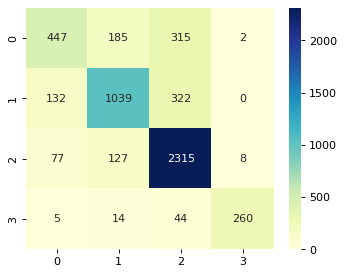

In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [25]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [26]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.47619047619047616
MSE: 0.7445200302343159
RMSE: 0.8628557412651989
R2 Square -0.02782203363094271
Accuracy 0.6494708994708994
__________________________________


In [27]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_VGG19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_VGG19
0,KNeighborsClassifier,0.31198,0.473356,0.688009,0.346524,0.767385
1,DecisionTreeClassifier,0.47619,0.744520,0.862856,-0.027822,0.649471


In [28]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.43      0.42      0.42       949
           1       0.61      0.60      0.60      1493
           2       0.76      0.76      0.76      2527
           3       0.65      0.69      0.67       323

    accuracy                           0.65      5292
   macro avg       0.61      0.62      0.61      5292
weighted avg       0.65      0.65      0.65      5292



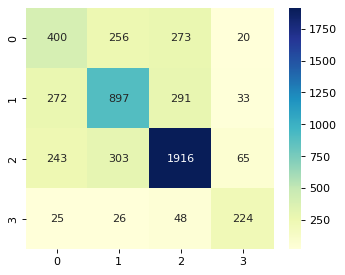

In [29]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [30]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [31]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [32]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.26511715797430085
MSE: 0.4087301587301587
RMSE: 0.6393200753379786
R2 Square 0.4357413556487997
Accuracy 0.8051776266061981
__________________________________


In [33]:
results_df_2 = pd.DataFrame(data=[["Lojistik regresyon", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_VGG19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_VGG19
0,KNeighborsClassifier,0.311980,0.473356,0.688009,0.346524,0.767385
1,DecisionTreeClassifier,0.476190,0.744520,0.862856,-0.027822,0.649471
2,Lojistik regresyon,0.265117,0.408730,0.639320,0.435741,0.805178


In [34]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.50      0.59       949
           1       0.79      0.79      0.79      1493
           2       0.83      0.92      0.87      2527
           3       0.92      0.88      0.90       323

    accuracy                           0.81      5292
   macro avg       0.81      0.77      0.79      5292
weighted avg       0.80      0.81      0.80      5292



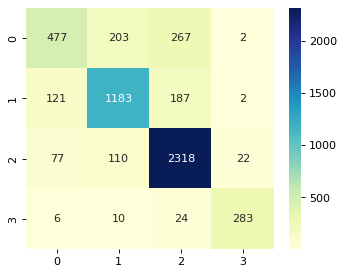

In [35]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [36]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [37]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [38]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.23809523809523808
MSE: 0.36130007558578986
RMSE: 0.6010824199606821
R2 Square 0.5012193582988927
Accuracy 0.8223733938019653
__________________________________


In [39]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_VGG19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_VGG19
0,KNeighborsClassifier,0.311980,0.473356,0.688009,0.346524,0.767385
1,DecisionTreeClassifier,0.476190,0.744520,0.862856,-0.027822,0.649471
2,Lojistik regresyon,0.265117,0.408730,0.639320,0.435741,0.805178
3,LGBMClassifier,0.238095,0.361300,0.601082,0.501219,0.822373


In [40]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.77      0.57      0.66       949
           1       0.79      0.81      0.80      1493
           2       0.84      0.92      0.88      2527
           3       0.96      0.88      0.91       323

    accuracy                           0.82      5292
   macro avg       0.84      0.79      0.81      5292
weighted avg       0.82      0.82      0.82      5292



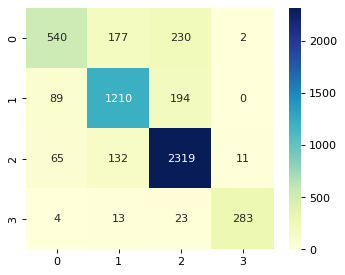

In [41]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [43]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [44]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.28779289493575205
MSE: 0.4295162509448224
RMSE: 0.6553748934349121
R2 Square 0.4070458166387988
Accuracy 0.7825018896447468
__________________________________


In [45]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_VGG19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_VGG19
0,KNeighborsClassifier,0.311980,0.473356,0.688009,0.346524,0.767385
1,DecisionTreeClassifier,0.476190,0.744520,0.862856,-0.027822,0.649471
2,Lojistik regresyon,0.265117,0.408730,0.639320,0.435741,0.805178
3,LGBMClassifier,0.238095,0.361300,0.601082,0.501219,0.822373
4,RandomForestClassifier,0.287793,0.429516,0.655375,0.407046,0.782502


In [46]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.80      0.41      0.54       949
           1       0.73      0.79      0.76      1493
           2       0.79      0.92      0.85      2527
           3       0.96      0.79      0.87       323

    accuracy                           0.78      5292
   macro avg       0.82      0.73      0.75      5292
weighted avg       0.79      0.78      0.77      5292



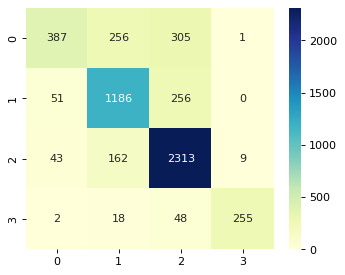

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [48]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [49]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [50]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.5398715041572184
MSE: 0.8970143613000756
RMSE: 0.947108421090255
R2 Square -0.23834294254976784
Accuracy 0.6201814058956916
__________________________________


In [51]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_VGG19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_VGG19
0,KNeighborsClassifier,0.311980,0.473356,0.688009,0.346524,0.767385
1,DecisionTreeClassifier,0.476190,0.744520,0.862856,-0.027822,0.649471
2,Lojistik regresyon,0.265117,0.408730,0.639320,0.435741,0.805178
3,LGBMClassifier,0.238095,0.361300,0.601082,0.501219,0.822373
4,RandomForestClassifier,0.287793,0.429516,0.655375,0.407046,0.782502
5,GaussianNB,0.539872,0.897014,0.947108,-0.238343,0.620181


In [52]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.53      0.22      0.31       949
           1       0.67      0.56      0.61      1493
           2       0.70      0.78      0.74      2527
           3       0.31      0.82      0.45       323

    accuracy                           0.62      5292
   macro avg       0.55      0.60      0.53      5292
weighted avg       0.64      0.62      0.61      5292



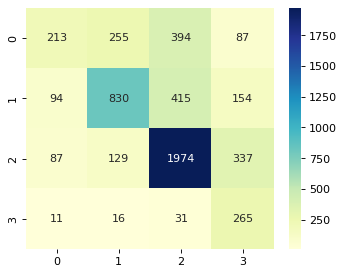

In [53]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [54]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [55]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [56]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.23223733938019653
MSE: 0.359599395313681
RMSE: 0.5996660698369394
R2 Square 0.5035671751269837
Accuracy 0.8301209372637944
__________________________________


In [57]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_VGG19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_VGG19
0,KNeighborsClassifier,0.311980,0.473356,0.688009,0.346524,0.767385
1,DecisionTreeClassifier,0.476190,0.744520,0.862856,-0.027822,0.649471
2,Lojistik regresyon,0.265117,0.408730,0.639320,0.435741,0.805178
3,LGBMClassifier,0.238095,0.361300,0.601082,0.501219,0.822373
4,RandomForestClassifier,0.287793,0.429516,0.655375,0.407046,0.782502
5,GaussianNB,0.539872,0.897014,0.947108,-0.238343,0.620181
6,SGDClassifier,0.232237,0.359599,0.599666,0.503567,0.830121


In [58]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.82      0.55      0.66       949
           1       0.81      0.82      0.82      1493
           2       0.83      0.94      0.88      2527
           3       0.99      0.84      0.91       323

    accuracy                           0.83      5292
   macro avg       0.86      0.79      0.81      5292
weighted avg       0.83      0.83      0.82      5292



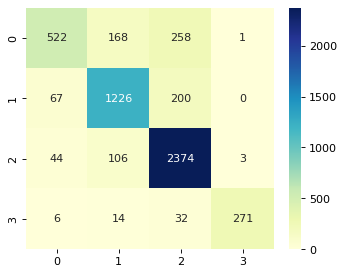

In [59]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [60]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [61]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [62]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.23715041572184428
MSE: 0.3531746031746032
RMSE: 0.5942849511594612
R2 Square 0.5124367053664386
Accuracy 0.8199168556311414
__________________________________


In [63]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_VGG19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_VGG19
0,KNeighborsClassifier,0.311980,0.473356,0.688009,0.346524,0.767385
1,DecisionTreeClassifier,0.476190,0.744520,0.862856,-0.027822,0.649471
2,Lojistik regresyon,0.265117,0.408730,0.639320,0.435741,0.805178
3,LGBMClassifier,0.238095,0.361300,0.601082,0.501219,0.822373
4,RandomForestClassifier,0.287793,0.429516,0.655375,0.407046,0.782502
5,GaussianNB,0.539872,0.897014,0.947108,-0.238343,0.620181
6,SGDClassifier,0.232237,0.359599,0.599666,0.503567,0.830121
7,SVC,0.237150,0.353175,0.594285,0.512437,0.819917


In [64]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       949
           1       0.80      0.77      0.79      1493
           2       0.86      0.89      0.87      2527
           3       0.93      0.90      0.92       323

    accuracy                           0.82      5292
   macro avg       0.82      0.81      0.82      5292
weighted avg       0.82      0.82      0.82      5292



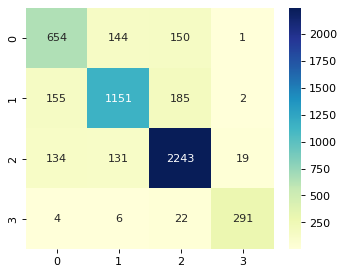

In [65]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [68]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model,svm_rbf_model]


In [69]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_VGG19"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_VGG19"])
    sonuclar = sonuclar.append(sonuc)
    

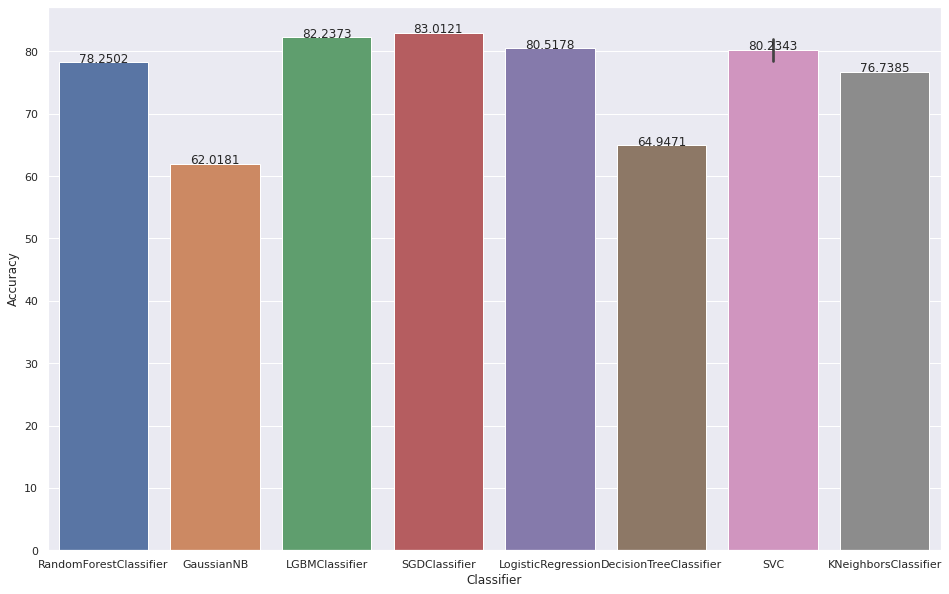

In [75]:
plt.figure(figsize=[16, 10])
axis = sns.barplot(x = 'Modeller', y = 'Accuracy_VGG19', data = sonuclar)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
  height = p.get_height()
  axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 

In [74]:
best_acc=sonuclar.sort_values(by=['Accuracy_VGG19'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model

,Modeller,Accuracy_VGG19
0,SGDClassifier,83.012094


In [76]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy_VGG19
0,KNeighborsClassifier,0.311980,0.473356,0.688009,0.346524,0.767385
1,DecisionTreeClassifier,0.476190,0.744520,0.862856,-0.027822,0.649471
2,Lojistik regresyon,0.265117,0.408730,0.639320,0.435741,0.805178
3,LGBMClassifier,0.238095,0.361300,0.601082,0.501219,0.822373
4,RandomForestClassifier,0.287793,0.429516,0.655375,0.407046,0.782502
5,GaussianNB,0.539872,0.897014,0.947108,-0.238343,0.620181
6,SGDClassifier,0.232237,0.359599,0.599666,0.503567,0.830121
7,SVC,0.237150,0.353175,0.594285,0.512437,0.819917


In [77]:
from google.colab import files

results_df.to_csv('output_vgg19.csv', encoding = 'utf-8-sig') 
files.download('output_vgg19.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>